In [2]:
import os
import glob
import math
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath('../preprocessing'))
import preprocess as prep

In [3]:
train_data_path = '/cache/gino/Data_for_DeepLearning/'
train_files_dir = '/cache/gino/Data_for_DeepLearning/train'

In [4]:
os.chdir(os.path.expanduser('~/projects/4D_MRI_CNN/'))
f = open('Folds/Fold1_train_all.txt')
probands = f.read().splitlines()
print(probands)

['2018-02-14_HNeb', '2018-04-24_HOlf', '2018-05-07_LRam', '2018-05-08_HOlf', '2018-05-23_GNig', '2018-05-23_HNeb', '2018-05-24_LTam', '2018-06-04_HNeb', '2018-06-04_LTam', '2018-06-07_GOht', '2018-06-08_SKiv']


In [5]:
file_names_all = {} ### all training nav files
for p in probands:
    file_names_all[p] = {}   
    
    regEx = os.path.join(train_files_dir, p, '*_D_*.nii.gz')
    file_names_all[p]['d'] = glob.glob(regEx)
    
    regEx = os.path.join(train_files_dir, p, '*_N_*.nii.gz')
    file_names_all[p]['n'] = glob.glob(regEx)

            
int_distr = {}
for p in probands:
    int_distr[p] = {}
    for f in ['max_norm', 'double_mean_norm', 'standardized']:        
        int_distr[p][f] = {}        
        keypoints = ['mean', 'max', 'min', 'mse', 'p99', 'p50', 'p20', 'mse']
        for kp in keypoints:
            int_distr[p][f][kp] = []

In [6]:
def standardization(img, mean, adjusted_stddev):
    return (img - mean) /  adjusted_stddev

In [7]:
for p in tqdm(probands):
    slice_norm_factor_doublemean = 1.0
    slice_norm_factor_max = 1.0
    with open(os.path.join(train_files_dir, p, 'normalization_factors.json'), 'r') as fp:
        data = json.load(fp)
        slice_norm_factor_doublemean = data['slice_double_mean']
        slice_norm_factor_max        = data['slice_max']
        slice_mean                   = data['slice_mean']
        slice_adjStd                 = data['slice_adjusted_std']
            
    for id in np.arange(0, len(file_names_all[p]['d']), 50):
        fn_d = file_names_all[p]['d'][id]
        fn_n = fn_d.replace('_D_', '_N_')
 
        img_d = sitk.ReadImage(fn_d)
        img_d = sitk.GetArrayFromImage(img_d)
        
        img_n = sitk.ReadImage(fn_n)
        img_n = sitk.GetArrayFromImage(img_n)

        ### normalize double mean
        diff_normed_dm   = (img_d / slice_norm_factor_doublemean) - (img_n / slice_norm_factor_doublemean)
        diff_normed_max = (img_d / slice_norm_factor_max) - (img_n / slice_norm_factor_max)
        diff_normed_standardized = standardization(img_d, slice_mean, slice_adjStd) - standardization(img_n, slice_mean, slice_adjStd)
        
        int_distr[p]['standardized']['mean'].append(np.mean(diff_normed_standardized))
        int_distr[p]['standardized']['max'].append(np.amax(diff_normed_standardized))
        int_distr[p]['standardized']['min'].append(np.amin(diff_normed_standardized))
        int_distr[p]['standardized']['mse'].append(np.mean(np.power(diff_normed_standardized, 2)))
        int_distr[p]['standardized']['p99'].append(np.percentile(diff_normed_standardized, 99))
        int_distr[p]['standardized']['p50'].append(np.percentile(diff_normed_standardized, 50))
        int_distr[p]['standardized']['p20'].append(np.percentile(diff_normed_standardized, 20))
        
        int_distr[p]['double_mean_norm']['mean'].append(np.mean(diff_normed_dm))
        int_distr[p]['double_mean_norm']['max'].append(np.amax(diff_normed_dm))
        int_distr[p]['double_mean_norm']['min'].append(np.amin(diff_normed_dm))
        int_distr[p]['double_mean_norm']['mse'].append(np.mean(np.power(diff_normed_dm, 2)))
        int_distr[p]['double_mean_norm']['p99'].append(np.percentile(diff_normed_dm, 99))
        int_distr[p]['double_mean_norm']['p50'].append(np.percentile(diff_normed_dm, 50))
        int_distr[p]['double_mean_norm']['p20'].append(np.percentile(diff_normed_dm, 20))
        
        int_distr[p]['max_norm']['mean'].append(np.mean(diff_normed_max))
        int_distr[p]['max_norm']['max'].append(np.amax(diff_normed_max))
        int_distr[p]['max_norm']['min'].append(np.amin(diff_normed_max))
        int_distr[p]['max_norm']['mse'].append(np.mean(np.power(diff_normed_max, 2)))
        int_distr[p]['max_norm']['p99'].append(np.percentile(diff_normed_max, 99))
        int_distr[p]['max_norm']['p50'].append(np.percentile(diff_normed_max, 50))
        int_distr[p]['max_norm']['p20'].append(np.percentile(diff_normed_max, 20))

100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


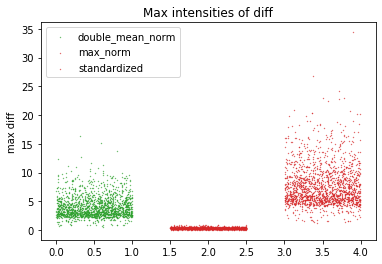

In [32]:
intensities_n = []
intensities_d = []
intensities_3 = []
for p in probands:
    intensities_n += int_distr[p]['double_mean_norm']['max']
    intensities_d += int_distr[p]['max_norm']['max']
    intensities_3 += int_distr[p]['standardized']['max']

x_n = np.random.rand(1, len(intensities_n))
x_d = np.random.rand(1, len(intensities_d))+1.5
x_3 = np.random.rand(1, len(intensities_d))+3

plt.scatter(x_n, intensities_n, c='tab:green', s=0.1, label='double_mean_norm') 
plt.scatter(x_d, intensities_d, c='tab:red', s=0.1, label='max_norm')   
plt.scatter(x_3, intensities_3, c='tab:red', s=0.1, label='standardized')   

plt.title('Max intensities of diff')
plt.legend()
plt.ylabel('max diff')
plt.show() 

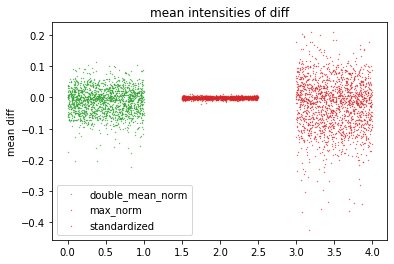

In [33]:
intensities_n = []
intensities_d = []
intensities_3 = []
for p in probands:
    intensities_n += int_distr[p]['double_mean_norm']['mean']
    intensities_d += int_distr[p]['max_norm']['mean']
    intensities_3 += int_distr[p]['standardized']['mean']

x_n = np.random.rand(1, len(intensities_n))
x_d = np.random.rand(1, len(intensities_d))+1.5
x_3 = np.random.rand(1, len(intensities_d))+3

plt.scatter(x_n, intensities_n, c='tab:green', s=0.1, label='double_mean_norm') 
plt.scatter(x_d, intensities_d, c='tab:red', s=0.1, label='max_norm')   
plt.scatter(x_3, intensities_3, c='tab:red', s=0.1, label='standardized')   

plt.title('mean intensities of diff')
plt.legend()
plt.ylabel('mean diff')
plt.show() 

mean mse 0.2450216392774506


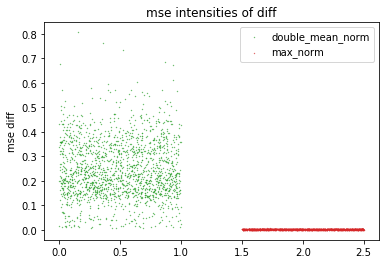

In [30]:
intensities_n = []
intensities_d = []
for p in probands:
    intensities_n += int_distr[p]['double_mean_norm']['mse']
    intensities_d += int_distr[p]['max_norm']['mse']

print('mean mse', np.mean(np.array(intensities_n)))
    
x_n = np.random.rand(1, len(intensities_n))
x_d = np.random.rand(1, len(intensities_d))+1.5

plt.scatter(x_n, intensities_n, c='tab:green', s=0.1, label='double_mean_norm') 
plt.scatter(x_d, intensities_d, c='tab:red', s=0.1, label='max_norm')   

plt.title('mse intensities of diff')
plt.legend()
plt.ylabel('mse diff')
plt.show() 

mean mse 0.8645433286930384


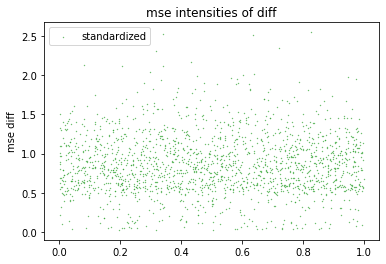

In [31]:
intensities_n = []
for p in probands:
    intensities_n += int_distr[p]['standardized']['mse']

print('mean mse', np.mean(np.array(intensities_n)))
    
x_n = np.random.rand(1, len(intensities_n))

plt.scatter(x_n, intensities_n, c='tab:green', s=0.1, label='standardized') 

plt.title('mse intensities of diff')
plt.legend()
plt.ylabel('mse diff')
plt.show() 